Prvi korak je učitavanje potrebnih biblioteka za izradu ovog projekta

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import cv2

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from tensorflow.keras.preprocessing.image import load_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


Učitavanje podataka

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl" -O data.zip && rm -rf /tmp/cookies.txt

--2022-09-12 15:44:20--  https://docs.google.com/uc?export=download&confirm=t&id=16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl
Resolving docs.google.com (docs.google.com)... 74.125.196.102, 74.125.196.139, 74.125.196.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.196.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hggpirbv2fomhuiemcaas1usv72v7p2j/1662997425000/06049624160957438625/*/16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl?e=download&uuid=1ea44906-a63b-4a02-aca9-ca390e0c0351 [following]
--2022-09-12 15:44:20--  https://doc-0k-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hggpirbv2fomhuiemcaas1usv72v7p2j/1662997425000/06049624160957438625/*/16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl?e=download&uuid=1ea44906-a63b-4a02-aca9-ca390e0c0351
Resolving doc-0k-64-docs.googleusercontent.com (doc-0k-64-docs.googleusercontent.com)... 74.125.28.132, 2

In [3]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

Pregled učitanih podataka

In [4]:
labels = pd.read_csv('/content/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


Broj različitih rasa:

In [6]:
labels['breed'].nunique()

120

Prikaz jedne fotografije iz skupa podataka

In [ ]:
from google.colab.patches import cv2_imshow
path = "/content/train/0067dc3eab0b3c3ef0439477624d85d6.jpg"
img = cv2.imread(path)
cv2_imshow(img)

Čuvanje putanja direktorijuma

In [7]:
train_dir = '/content/train/'
test_dir = '/content/test/'


In [8]:
print("Number of dog's images in train directory",len(os.listdir(train_dir)))
print("Number of dog's images in test directory",len(os.listdir(test_dir)))

Number of dog's images in train directory 10222
Number of dog's images in test directory 10357


Prikaz količine fotografija u odnosu na rasu

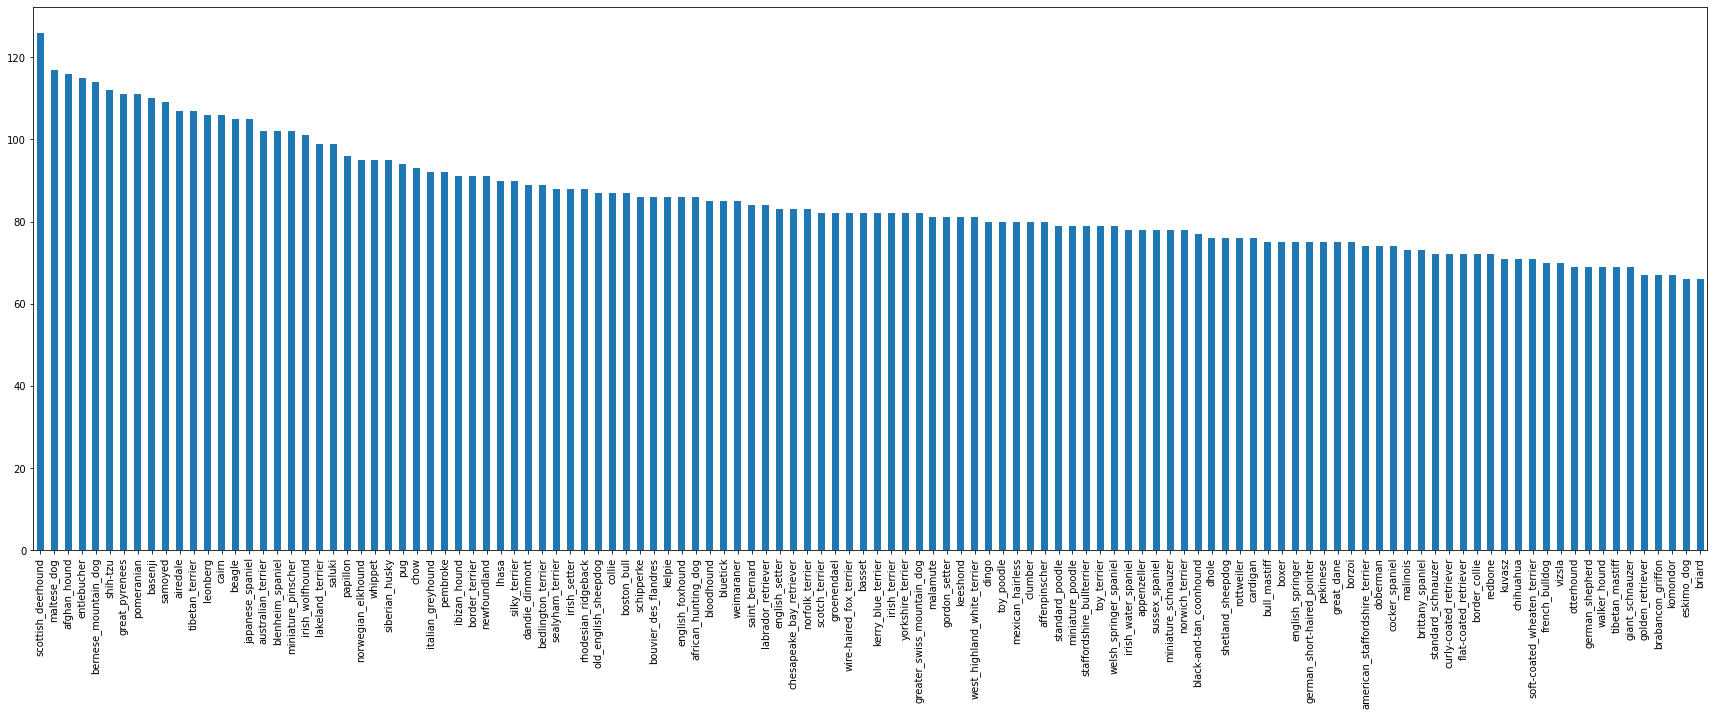

In [10]:
labels["breed"].value_counts().plot.bar(figsize=(30,10))

Proveravanje saglasnosti broja fotografija i labela

In [9]:
if len(os.listdir(train_dir)) == len(labels['id']):
    print('Number of labels matches the number of images!')
else:
    print('Number of labels does not match the number of images!')

Number of labels matches the number of images!


# **Predprocesuiranje podataka**

Kreiranje liste sa sortiranim nazivima rasa



In [10]:
breeds = sorted(list(set(labels['breed'])))
n_classes = len(breeds)
print('Total number of unique breeds: ', n_classes)

Total number of unique breeds:  120


Mapiranje labela na numeričke vrednosti od 0 do 119

In [11]:
breed_to_num = dict(zip(breeds, range(n_classes)))
breed_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

# One hot encoding
Definicija funkcije za smeštanje fotografija u niz

In [12]:
#smanjivanje rezolucije fotografija kako bi sve bile istih dimenzija
input_shape = (250, 250, 3)

def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    X = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8)
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
      
    for i, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img_pixels = load_img(img_dir, target_size = target_size)
        X[i]=img_pixels
        
        dog_breed = image_labels[i]
        y[i] = breed_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return X,y

Pozivanje definisane funkcije

In [13]:
X,y = images_to_array(train_dir, labels[:])

  0%|          | 0/10222 [00:00<?, ?it/s]

In [14]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [15]:
X[0]

array([[[153,  91,  40],
        [182, 127,  73],
        [172, 123,  67],
        ...,
        [198, 178,  45],
        [176, 144,  71],
        [214, 182, 109]],

       [[189, 136,  94],
        [142,  95,  51],
        [148, 108,  59],
        ...,
        [233, 208,  90],
        [200, 168,  81],
        [200, 168,  81]],

       [[156, 110,  74],
        [119,  77,  39],
        [206, 169, 127],
        ...,
        [239, 210, 108],
        [213, 180,  83],
        [207, 174,  77]],

       ...,

       [[187, 120,  67],
        [183, 116,  63],
        [190, 124,  72],
        ...,
        [219, 166, 114],
        [221, 168, 118],
        [214, 161, 111]],

       [[186, 119,  66],
        [184, 117,  64],
        [190, 124,  72],
        ...,
        [190, 132,  84],
        [213, 160, 108],
        [209, 156, 104]],

       [[181, 114,  61],
        [186, 119,  66],
        [191, 125,  73],
        ...,
        [167, 100,  58],
        [184, 132,  74],
        [192, 140,  82]]

Prikaz fotografija nakon obrade

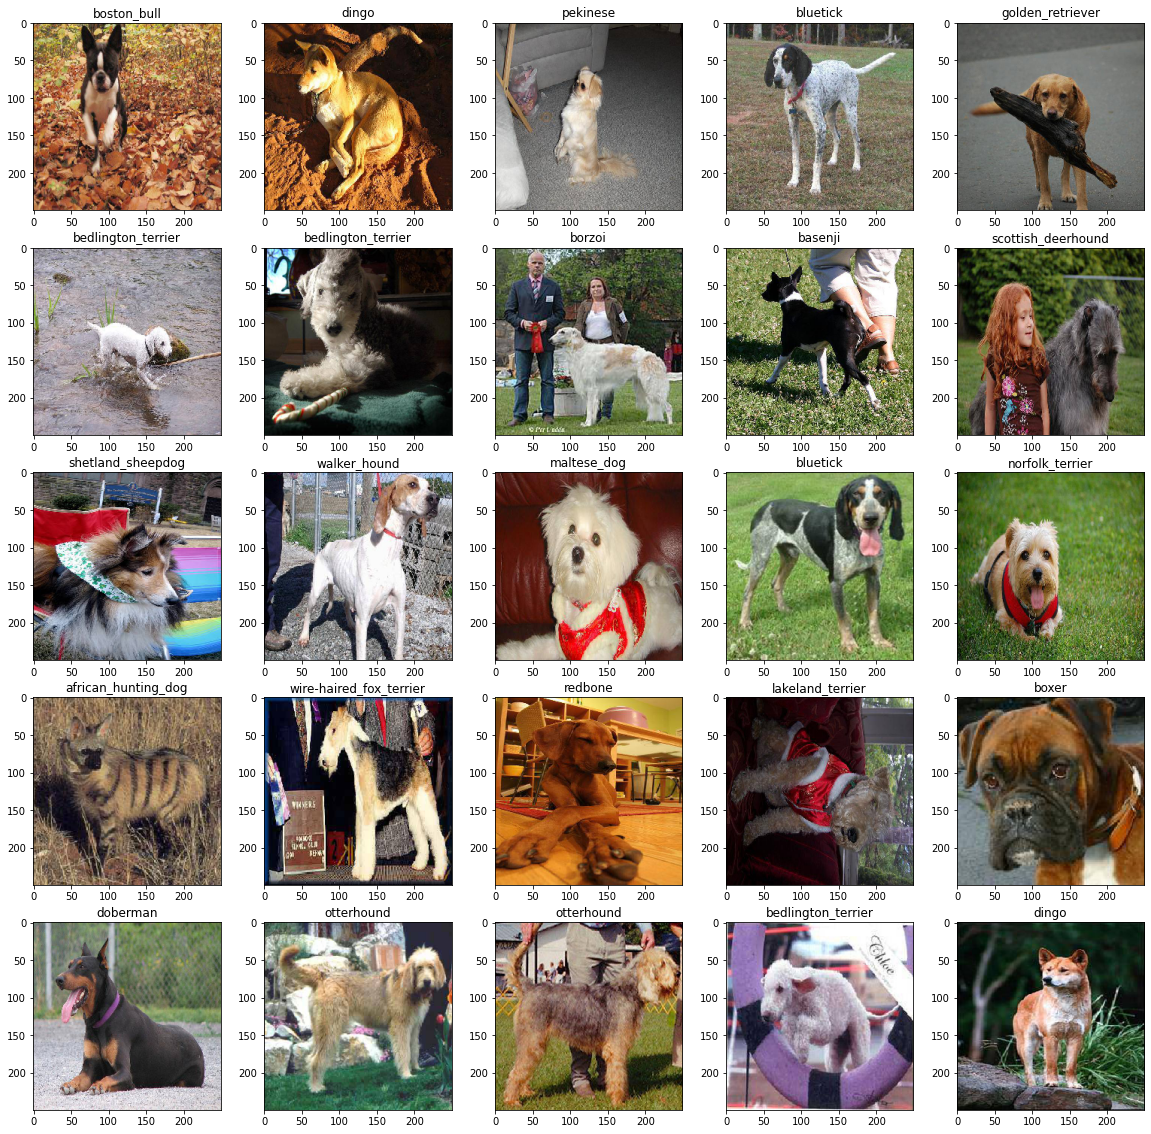

In [16]:
plt.figure(figsize=(20,20))

for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.title(breeds[np.where(y[i]==1)[0][0]])
    plt.imshow(X[i].astype('int32'))

# Kreiranje Callback-a
Kreiraju se pomoćne funkcije koje model koristi tokom obučavanja kako bi se preciznije vodila evidencija o napretku modela, izvršila provera napretka ili obustavila obuka ukoliko model ne beleži napredak.
U ovom slučaju stopa učenja biće smanjena za 0.1 kada metrika prestane da se poboljšava.
U slučaju da model ne pokazuje poboljšanja učenje modela se prekida.

In [17]:
ReduceLROnPlateau_callback= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)
EarlyStop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#my_callback=[EarlyStop_callback]

# Algoritmi za optimizaciju

Najzastupljeniji algoritam za obučavanje neuronskih mreža. Zasniva se na ocenama prvog i drugog momenta gradijenata.

U okviru ovog dela korišćeni su hiperparametri. Oni predstavljaju parametre modela koji se ne uče, već se određuju prilikom izgradnje modela pre treniranja modela. Vrednosti ovih parametara kontrolišu učenje modela.

In [18]:
#hiperparametri
batch_size= 128
epochs=50
learn_rate=.001

adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

# Izdvajanje karakteristika

U ovom koraku se izdvajanju karakteristike iz skupa podataka i kreiraju jednsotavnu duboku neuronsku mrezu koristeci kombinaciju tih karakteristika. Uvodi se GlobalAveragePooling2D() za filtriranje mape feature-a.

In [3]:
img_size = (250,250,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #izdvajanje feature-a
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

# InceptionV3

InceptionV3 je model koji pomaže prilikom analize fotografija i detekcije objekata i sastoji se iy 48 slojeva.

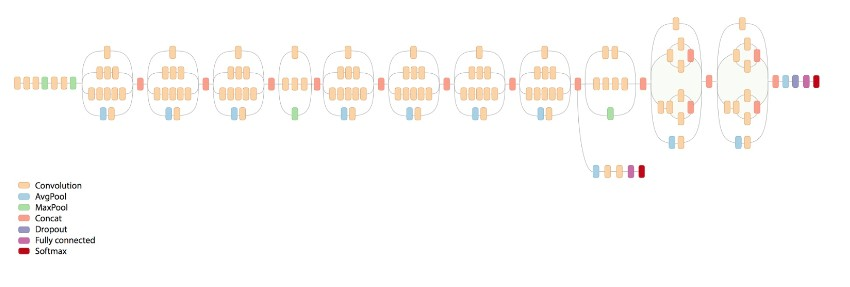

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

# Xception

Xception je konvoluciona neuronska mreža koja je duboka 71 sloj. Pomoću nje takođe izdvajamo feature.

In [ ]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

Kreiranje mape feature-ova

In [ ]:
final_features = np.concatenate([inception_features,
                                 xception_features], axis=-1)

print('Final features map shape', final_features.shape)

# Treniranje modela
Najveća prezicnost je zabeležena u 16. epohi - 0.9577. Pomoću callback funckija, treniranje je prekinuto posle 16. epohe iako je broj definisanih epoha bio 50.

In [ ]:
gc.collect()
model = Sequential()
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#treniranje modela 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[ReduceLROnPlateau_callback,EarlyStop_callback])


Prikaz preciznosti modela

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Testiranje modela

Definicija funkcije za čitanje podataka iz test direktorijuma

In [ ]:
def img_to_array_test(test_path, img_size = (250,250,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for i,img_dir in enumerate(tqdm(test_filenames)):
        img = load_img(img_dir, target_size = img_size)
        images[i]=img
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = img_to_array_test('/content/test/', img_size)

Izdvajanje features-a fotografija za testiranje

In [ ]:
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features],axis=-1)
    
    print('Final features map shape', final_features.shape)

    del inception_features
    del xception_features
    gc.collect()
    
    
    return final_features


Poziv definisane funkcije

In [ ]:
test_features = extact_features(test_data)

Predviđanje labele za test podatke

In [ ]:
pred = model.predict(test_features)

Upisivanje rezultata predikcije u csv fajl

In [ ]:
sample_df = pd.read_csv('/content/sample_submission.csv/')
for b in breeds:
    sample_df[b] = pred[:,breed_to_num[b]]
sample_df.to_csv('/content/submission_predictions.csv', index=None)